# Mining Segmentation Training Example

This notebook demonstrates how to train and evaluate the UNet model for mining segmentation.

## Setup

In [1]:
import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from network.unet import build_unet
from network.train import MiningSegmentationTrainer
from network.evaluate import MiningSegmentationEvaluator
from network.config import NetworkConfig
from data.data_loader import MiningSegmentationDataLoader

print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

2026-02-03 18:19:22.080526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.18.0
GPUs available: 0


## 1. Explore Available Data

In [2]:
# Initialize data loader
data_loader = MiningSegmentationDataLoader(
    # db_path="../../data/mining_segmentation.db",
    # zarr_path="../../data/global_landsat.zarr/"
)

# Get statistics
stats = data_loader.get_tile_statistics()

print(f"Total tiles available: {stats['total_tiles']}")
print(f"\nCountries: {stats['countries']}")
print(f"\nYears: {stats['years']}")
print(f"\nClusters: {stats['clusters']}")

/Users/felixschulz/miniforge3/envs/tensorflow/lib/python3.12/site-packages/zarr/core/group.py:3535: ZarrUserWarning: Object at .DS_Store is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
2026-02-03 18:19:32,097 - data.data_loader - INFO - Initialized data loader with zarr: /Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Job/UNI/Basel/Research/mining-net/data/global_landsat.zarr


Total tiles available: 64

Countries: {'ISL': 64}

Years: {2019: 64}

Clusters: {0: 64}


## 2. Load and Visualize Sample Data

In [3]:
len(data_loader.get_written_tiles(years=[2019]))

64

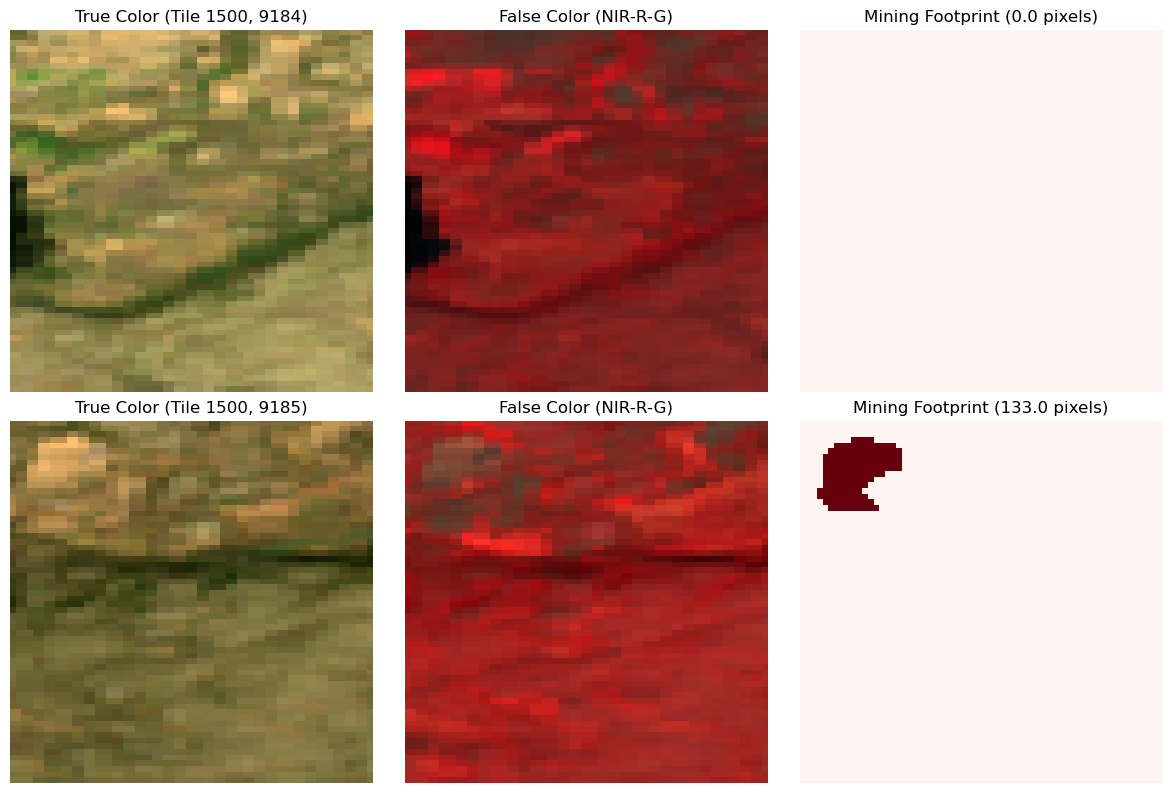

In [4]:
# Get some sample tiles
sample_tiles = data_loader.get_written_tiles(years=[2019])[23:25]

fig, axes = plt.subplots(len(sample_tiles), 3, figsize=(12, 4*len(sample_tiles)))
if len(sample_tiles) == 1:
    axes = axes[np.newaxis, :]

for i, tile in enumerate(sample_tiles):
    # Load tile
    features, labels = data_loader.load_tile_data(
        tile['tile_ix'],
        tile['tile_iy'],
        bands=['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal']
    )
    
    # Replace NaN
    features = np.nan_to_num(features, nan=0.0)
    labels = np.nan_to_num(labels, nan=0)
    
    # True color RGB
    rgb = features[:, :, [2, 1, 0]]  # Red, Green, Blue
    rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
    axes[i, 0].imshow(rgb)
    axes[i, 0].set_title(f'True Color (Tile {tile["tile_ix"]}, {tile["tile_iy"]})')
    axes[i, 0].axis('off')
    
    # False color (NIR, Red, Green)
    false_color = features[:, :, [3, 2, 1]]  # NIR, Red, Green
    false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
    axes[i, 1].imshow(false_color)
    axes[i, 1].set_title('False Color (NIR-R-G)')
    axes[i, 1].axis('off')
    
    # Mining footprint
    axes[i, 2].imshow(labels, cmap='Reds', vmin=0, vmax=1)
    axes[i, 2].set_title(f'Mining Footprint ({labels.sum()} pixels)')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

## 3. Build and Inspect Model

In [5]:
# Build model
model = build_unet(
    input_shape=(64, 64, 7),
    num_classes=1,
    filters_base=64,
    depth=2,
    dropout_rate=0.1
)

model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_0 (EncoderBlock)        │ ?                      │        41,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (EncoderBlock)        │ ?                      │       222,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (ConvBlock)          │ ?                      │       887,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (DecoderBlock)        │ ?                      │       574,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_0 (DecoderBlock)        │ ?                      │       144,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Conv2D)                 │ (1, 64, 64, 1)         │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,870,273 (7.13 MB)

 Trainable params: 1,867,713 (7.12 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [6]:
# Test forward pass
test_input = tf.random.normal((2, 64, 64, 7))
test_output = model(test_input)

print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Output range: [{test_output.numpy().min():.3f}, {test_output.numpy().max():.3f}]")

Input shape: (2, 64, 64, 7)
Output shape: (2, 64, 64, 1)
Output range: [0.328, 0.996]


## 4. Configure Training

In [7]:
# Setup configuration
config = NetworkConfig()

# Adjust for quick testing (reduce for full training)
config.EPOCHS = 10
config.BATCH_SIZE = 16
config.EARLY_STOPPING_PATIENCE = 5

# Loss and augmentation
config.LOSS_TYPE = 'combined'
config.USE_AUGMENTATION = True

# Display configuration
print("Training Configuration:")
print(f"  Epochs: {config.EPOCHS}")
print(f"  Batch size: {config.BATCH_SIZE}")
print(f"  Learning rate: {config.LEARNING_RATE}")
print(f"  Loss type: {config.LOSS_TYPE}")
print(f"  Augmentation: {config.USE_AUGMENTATION}")

Training Configuration:
  Epochs: 10
  Batch size: 16
  Learning rate: 0.0001
  Loss type: combined
  Augmentation: True


## 5. Train Model

In [ ]:
# Initialize trainer
trainer = MiningSegmentationTrainer(network_config=config)

# Train model (adjust filters as needed)
history = trainer.train(
    countries=['ISL'],
    years=[2019],
    run_name='mining_unet_demo'
)

print("\nTraining completed!")

/Users/felixschulz/miniforge3/envs/tensorflow/lib/python3.12/site-packages/zarr/core/group.py:3535: ZarrUserWarning: Object at .DS_Store is not recognized as a component of a Zarr hierarchy.
  warnings.warn(
2026-02-03 18:19:43,011 - data.data_loader - INFO - Initialized data loader with zarr: /Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Job/UNI/Basel/Research/mining-net/data/global_landsat.zarr
2026-02-03 18:19:43,012 - network.train - INFO - Mixed precision training enabled
2026-02-03 18:19:43,014 - network.train - INFO - Starting training run: mining_unet_demo
2026-02-03 18:19:43,018 - network.train - INFO - Building UNet model...
2026-02-03 18:19:44,636 - network.train - INFO - Model compiled successfully


2026-02-03 18:19:44,648 - network.train - INFO - Model: "unet"
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_0 (EncoderBlock)        │ ?                      │        41,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_1 (EncoderBlock)        │ ?                      │       222,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (ConvBlock)          │ ?                      │       887,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (DecoderBlock)        │ ?                      │       574,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_0 (DecoderBlock)        │ ?                      │       144,064 │
├────────────

Epoch 1/10


## 6. Evaluate Model

In [ ]:
# Get the best checkpoint path
checkpoint_path = config.CHECKPOINT_DIR / 'mining_unet_demo_best.h5'

# Initialize evaluator
evaluator = MiningSegmentationEvaluator(str(checkpoint_path), network_config=config)

# Evaluate on validation data
results = evaluator.evaluate(
    countries=['ICL'],
    years=[2019],
    batch_size=16
)

print("\nEvaluation Results:")
for metric, value in results.items():
    print(f"  {metric}: {value:.4f}")

## 7. Visualize Predictions

In [ ]:
# Visualize predictions on sample tiles
evaluator.visualize_predictions(
    # countries=['ZAF'],
    num_samples=4
)

## 8. Predict on Individual Tiles

In [ ]:
# Get a test tile
test_tiles = data_loader.get_written_tiles()[:1]
tile = test_tiles[0]

# Predict
features, ground_truth, prediction = evaluator.predict_tile(
    tile['tile_ix'],
    tile['tile_iy']
)

# Visualize
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# False color composite
false_color = features[:, :, [3, 2, 1]]  # NIR, Red, Green
false_color = (false_color - false_color.min()) / (false_color.max() - false_color.min() + 1e-8)
axes[0].imshow(false_color)
axes[0].set_title('False Color Composite')
axes[0].axis('off')

# Ground truth
axes[1].imshow(ground_truth, cmap='Reds', vmin=0, vmax=1)
axes[1].set_title('Ground Truth')
axes[1].axis('off')

# Prediction (probability)
axes[2].imshow(prediction[:, :, 0], cmap='Reds', vmin=0, vmax=1)
axes[2].set_title('Prediction (Probability)')
axes[2].axis('off')

# Overlay
axes[3].imshow(false_color)
axes[3].imshow(prediction[:, :, 0], cmap='Reds', alpha=0.5, vmin=0, vmax=1)
axes[3].set_title('Prediction Overlay')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Compute metrics for this tile
pred_binary = (prediction[:, :, 0] > 0.5).astype(float)
intersection = (ground_truth * pred_binary).sum()
union = ground_truth.sum() + pred_binary.sum() - intersection
iou = intersection / (union + 1e-8)
dice = 2 * intersection / (ground_truth.sum() + pred_binary.sum() + 1e-8)

print(f"\nTile {tile['tile_ix']}, {tile['tile_iy']} Metrics:")
print(f"  IoU: {iou:.4f}")
print(f"  Dice: {dice:.4f}")
print(f"  Ground truth pixels: {ground_truth.sum():.0f}")
print(f"  Predicted pixels: {pred_binary.sum():.0f}")

## 9. Export Predictions (Optional)

In [ ]:
# Uncomment to export all predictions
# evaluator.export_predictions(
#     output_dir='predictions/',
#     threshold=0.5
# )